In [1]:
import pandas as pd
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

df = pd.read_csv('coincident_peaks.csv')
df

,Coincident_hour,Year,Month,day_of_month,week_of_year,day_of_year,day_of_week
0,17,2021,1,25,5,25,4
1,17,2020,12,13,51,348,6
2,17,2020,11,19,47,324,5
3,18,2020,10,22,43,296,1
4,17,2020,9,10,37,254,3
...,...,...,...,...,...,...,...
176,15,2006,5,18,20,139,4
177,14,2006,4,28,17,119,7
178,19,2006,3,2,9,62,2
179,18,2006,2,16,7,48,2


In [2]:
df.dtypes

Coincident_hour    int64
Year               int64
Month              int64
day_of_month       int64
week_of_year       int64
day_of_year        int64
day_of_week        int64
dtype: object

In [3]:
df['year_number'] = df['Year'] - 2005
df

,Coincident_hour,Year,Month,day_of_month,week_of_year,day_of_year,day_of_week,year_number
0,17,2021,1,25,5,25,4,16
1,17,2020,12,13,51,348,6,15
2,17,2020,11,19,47,324,5,15
3,18,2020,10,22,43,296,1,15
4,17,2020,9,10,37,254,3,15
...,...,...,...,...,...,...,...,...
176,15,2006,5,18,20,139,4,1
177,14,2006,4,28,17,119,7,1
178,19,2006,3,2,9,62,2,1
179,18,2006,2,16,7,48,2,1


In [4]:
df.columns

Index(['Coincident_hour', 'Year', 'Month', 'day_of_month', 'week_of_year',
       'day_of_year', 'day_of_week', 'year_number'],
      dtype='object')

In [5]:
#Create the training and testing data sets.
np.random.seed(0)
mask = np.random.rand(len(df)) < 0.7
df_train = df[mask]
df_test = df[~mask]
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

Training data set length=131
Testing data set length=50


In [6]:
#Setup the regression expression in patsy notation. We are telling patsy that BB_COUNT is our dependent variable and
# it depends on the regression variables: DAY, DAY_OF_WEEK, MONTH, HIGH_T, LOW_T and PRECIP.
#expr = """Coincident_hour ~ Year  + Month + day_of_month + week_of_year + day_of_year +  day_of_week """
#expr = """Coincident_hour ~ year_number + Month + day_of_month + week_of_year + day_of_year +  day_of_week """

expr = """Coincident_hour ~ year_number + Month + day_of_month + week_of_year + day_of_year +  day_of_week """

#Set up the X and y matrices
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

#Using the statsmodels GLM class, train the Poisson regression model on the training data set.
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

#Print the training summary.
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:        Coincident_hour   No. Observations:                  131
Model:                            GLM   Df Residuals:                      124
Model Family:                 Poisson   Df Model:                            6
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -324.09
Date:                Mon, 15 Feb 2021   Deviance:                       44.340
Time:                        14:29:48   Pearson chi2:                     41.2
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        4.0707      0.870      4.680   

In [2]:
#Make some predictions on the test data set.
poisson_predictions = poisson_training_results.get_prediction(X_test)
#.summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)

NameError: name 'poisson_training_results' is not defined

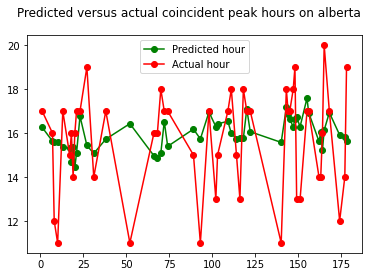

In [9]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['Coincident_hour']

#Mlot the predicted counts versus the actual counts for the test data.
fig = plt.figure()
fig.suptitle('Predicted versus actual coincident peak hours on alberta')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted hour')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual hour')
plt.legend(handles=[predicted, actual])
plt.show()

<Figure size 432x288 with 0 Axes>

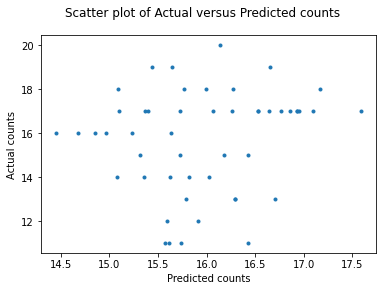

In [10]:
#Show scatter plot of Actual versus Predicted counts
plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts')
plt.scatter(x=predicted_counts, y=actual_counts, marker='.')
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')
plt.show()

In [1]:
df_test['prediction_mean'] = predictions_summary_frame['mean']
df_test['prediction_mean_ci_upper'] = predictions_summary_frame['mean_ci_upper']
df_test['prediction_mean_ci_upper'] = df_test['prediction_mean_ci_upper'].apply(np.ceil)
df_test

NameError: name 'predictions_summary_frame' is not defined

In [21]:
'''
expr = """Coincident_hour ~ year_number + Month + day_of_month + week_of_year + day_of_year +  day_of_week """
'''
prediction_input = np.array([1, 15,2,15,8,46,2])
out = poisson_training_results.get_prediction(prediction_input)
out.summary_frame()

,mean,mean_se,mean_ci_lower,mean_ci_upper
0,15.757666,0.984625,13.941329,17.810642
